# Convolutional Neural Network: Image Classification
# Management of Wild Horse Herds in U.S. Public Land

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

# TensorFlow / Keras functions
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2

### Overpopulation of wild horses
There are currently 95,000 wild horses roaming U.S. public lands. This number
represents an overpopulation that poses a threat to land resources and the wild
horse herds themselves as public lands can reach their capability limit. Land resources
are exhausted to the point of not being able to sustain native species and even the
wild horse herds. 

The U.S. Bureau of Land Management (BLM) is tasked with
overseeing the wild horse herds and it estimates that land resources available only
have the capability to sustain 27,000 horses. This leaves the BLM with the daunting
task of managing the estimated excess of 68,000 horses.

Currently the BLM uses methods like sterilization and roundups to reduce the
number of wild horses, but these methods are controversial. According to experts,
sudden reductions in animal populations can lead to a natural rebound in population
through compensatory reproduction; birth rates increase in response to the unnatural
reduction. Animal advocates argue round-ups can physically hurt the animals who
then end up in overcrowded facilities.

### Proposed Solution: Convolutional Neural Network (CNN)
We propose the use of a convolutional neural network for a binary classification model that can identify horses from images obtained in different regions of the U.S. where it is critical to keep horse
population and their range in check. In practice, images obtained through drones and
trail cameras would be uploaded into a dataset and classified by the model. Images
classified as a horse would be reviewed to determine proper further actions to take.
This perhaps would be an efficient supplemental tool to aid in addressing
overpopulation

### CNN General Overview
CNN extracts relevant features from an image in the initial convolution layer,
it could be the outline or whole pieces of different areas of the image, such as ears or
head which makes the model ideal for image classification. The extracted features are
then pooled to recreate a reduced image of the original one and then fed to a dense
layer that will recognize patterns between the pixels from the pooled image to
classify the image. 

![CNN Overview](./cnn1.png)

Different number of convolution and pooling layers can be used to tune the model. Set up is always
convolution layer first, followed by pooling, repeating the pattern as necessary then
moving on to dense layer which is a neural network that can also have multiple layers
before finally classifying the image. Increasing model complexity can potentially increase
model performance but optimization also becomes complex, making it difficult to
tune parameters, which is a disadvantage of CNN on top of an increase in training time.

### Defined functions used in data analysis and modeling

* User defined function to display images from an array of images for the selected indices

In [2]:
def display_images(image_array, indices, n_col=10, n_row=1):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(image_array[indices[i]])
        plt.xticks
        plt.yticks
    plt.show()

* User defined function to load and split the data using cifar10.load_data()

In [3]:
def load_and_split_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train.shape, y_train.shape, X_test.shape, y_test.shape
   # Split X_train into training dataset and validation dataset.
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                         y_train, 
                                                         stratify = y_train, 
                                                         test_size = 0.2, 
                                                         random_state = 1842
                                                        )
    display_shape(X_train, y_train, X_valid, y_valid, X_test, y_test)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

* User defined function to load and Split the data using cifar10.load_data()

In [4]:
def display_shape(X_train, y_train, X_valid, y_valid, X_test, y_test):
    print(f" X_train shape :{X_train.shape}")
    print(f" X_valid shape :{X_valid.shape}")
    print(f" X_test shape :{X_test.shape}\n")
    print(f" y_train shape :{y_train.shape}")
    print(f" y_valid shape :{y_valid.shape}")
    print(f" y_test shape :{y_test.shape}\n")

    print(f" Unique response parameters in Training Data   : {np.unique(y_train, return_counts=False)}")
    print(f" Unique response parameters in Validation Data : {np.unique(y_test, return_counts=False)}")
    print(f" Unique response parameters in Test Data       : {np.unique(y_valid, return_counts=False)}\n")

* User defined function to explore the data

In [5]:
def explore_data(X_train, y_train, X_valid, y_valid, X_test, y_test, display_shape=True):
    if (display_shape):
          display_shape(X_train, y_train, X_valid, y_valid, X_test, y_test)

    cnt_unique_classes = np.unique(y_train, return_counts=False)
    print("\nExamples of Images from the Training Dataset per Class")
    for i in cnt_unique_classes:
        train_indices = np.asarray(np.where(y_train == i)).reshape(-1)
        display_images(X_train, train_indices)

* User defined function to preprocess the datasets

In [6]:
def preProcess(X_data, y_data):
    #Filtered dataset to only contain relevant images
    data_indices = ((y_data == 2)| (y_data == 4)| (y_data == 7)).reshape(-1)
    newX_data = X_data[data_indices]
    newy_data = y_data[data_indices]
    #Encoded non-horse images as 0 and horse images as 1 for the purpose of binary classification
    newy_data[newy_data != 7] = 0
    newy_data[newy_data == 7] = 1
    return newX_data, newy_data

* **Defining Initial CNN Model:**
    - 2 convolutional layers
    - 2 Pooling layers
    - 2 dense layers with "relu" activation, 
    - 1 dense layer with "sigmoid" activation for binary classification

In [7]:
def define_initial_model():
    tf.random.set_seed(1842)
    i_model = Sequential()
    i_model.add(Conv2D(2, kernel_size=3, activation="relu", padding="same",input_shape=(32, 32, 3)))
    i_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    i_model.add(Conv2D(2, kernel_size=3, activation="relu", padding="same"))
    i_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    i_model.add(Flatten())
    i_model.add(Dense(8, activation="relu"))
    i_model.add(Dense(16, activation="relu"))
    i_model.add(Dense(1, activation="sigmoid"))
    i_model.summary()
    i_model.compile(optimizer="adam",
    loss="binary_crossentropy",

    metrics=["accuracy", "Precision", "Recall", "AUC"])

    return i_model

* **Defining Optimized CNN Model:**
  - Added additional convolutional layers and max pool layers 
  - Tuned activation functions and padding
  - Added additional dense layers with kernel regularizers

In [8]:
def define_optimized_model():
    tf.random.set_seed(1842)
    opt_model = Sequential()
    
    opt_model.add(Conv2D(32, kernel_size=3, activation="relu", padding="same",
    input_shape=(32, 32, 3)))
    opt_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    opt_model.add(Conv2D(64, kernel_size=3, activation="relu", padding="same"))
    opt_model.add(MaxPooling2D(pool_size=(4, 4), strides=2))
    opt_model.add(Conv2D(128, kernel_size=3, activation="relu", padding="same"))
    opt_model.add(MaxPooling2D(pool_size=(4, 4), strides=2))
    opt_model.add(Flatten())
    
    opt_model.add(Dense(512,kernel_regularizer=l2(0.1), activation="relu"))
    opt_model.add(Dropout(0.4))
    opt_model.add(Dense(128, kernel_regularizer=l2(0.1), activation="relu"))
    opt_model.add(Dense(112, kernel_regularizer=l2(0.1), activation="relu"))
    opt_model.add(Dense(96, kernel_regularizer=l2(0.1), activation="relu"))
    opt_model.add(Dense(64, kernel_regularizer=l2(0.1), activation="relu"))
    opt_model.add(Dense(32, kernel_regularizer=l2(0.1), activation="relu"))
    opt_model.add(Dense(16, kernel_regularizer=l2(0.1), activation="relu"))
    opt_model.add(Dense(1, activation="sigmoid"))
    opt_model.summary()
    opt_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy", "Precision", "Recall", "AUC"]
    )
    return opt_model

* User defined function to plot the confusion matrix to assess model performance

In [9]:
def display_confMatrix_classReport(preds, y, labels=["Horse", "Not Horse"]):
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix = metrics.confusion_matrix(y, preds),
        display_labels = labels)
    cm_display.plot()
    plt.show()
    print('Metrics for Model Performance on the Testing Set')
    print(metrics.classification_report(preds,
                                        y,
                                        target_names=labels,
                                        zero_division=0))

* User defined function to plot the features maps from the convolutional and/or pooling layer

In [10]:
def PlotFeatureMaps(output_predictions):
    n_col = 3
    n_row = 3 
    plt.figure(figsize=(10, 5))
    for j in range(n_row * n_col):
        plt.subplot(n_row, n_col, j + 1)
        plt.imshow(output_predictions[0, :, :, j], cmap=plt.cm.binary)
        plt.xticks(())
        plt.yticks(())
    plt.show
    return None

* User defined function to plot cross entropy loss used to analyze the model performance 

In [11]:
def summarize_model_diagnostics(model_history, model_results):
    plt.figure(figsize=(10, 5))
    #plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(model_history.history['loss'], color='blue', label='Training')
    plt.plot(model_history.history['val_loss'], color='orange', label='Validation')
    plt.xlabel("Epochs")
    plt.legend()
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(model_history.history['accuracy'], color='blue', label='Training')
    plt.plot(model_history.history['val_accuracy'], color='orange', label='Validation')
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    print('Model Performance on the Test Set')
    print(f"Model Performance")
    print(f"Accuracy : {model_results[1]}")
    print(f"Precision : {model_results[2]}")
    print(f"Recall : {model_results[3]}")
    print(f"AUC : {model_results[4]}")
    print(f"LOSS : {model_results[0]}")
    return model_results[1], model_results[2], model_results[3], model_results[4], model_results[0]

### Loading and Splitting Data For Modeling
Images from the The CIFAR-10 dataset were used for the purpose of training a model that could classify horse images.

In [12]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_split_data()

 X_train shape :(40000, 32, 32, 3)
 X_valid shape :(10000, 32, 32, 3)
 X_test shape :(10000, 32, 32, 3)

 y_train shape :(40000, 1)
 y_valid shape :(10000, 1)
 y_test shape :(10000, 1)

 Unique response parameters in Training Data   : [0 1 2 3 4 5 6 7 8 9]
 Unique response parameters in Validation Data : [0 1 2 3 4 5 6 7 8 9]
 Unique response parameters in Test Data       : [0 1 2 3 4 5 6 7 8 9]



<li>The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes</li>
<li>There are 6000 images per class.</li> 
<li>We chose to split the images into 3 groups to start with</li>
<li>40000 will be grouped for training images</li>
<li>10000 will be grouped for validation images</li>
<li>10000 will be grouped for test images</li>

### Data Exploration

__EDA Observations__

<B>10 unique classes:</B>
<li>airplane</li>										
<li>automobile</li>										
<li>bird</li>
<li>cat</li>										
<li>deer</li>										
<li>dog</li>										
<li>frog</li>										
<li>horse</li>										
<li>ship</li>										
<li>truck</li>

The classes are completely mutually exclusive.<BR> 
Our mission is to design a ML model to identify horses given an image<BR>
Our group decided to filter and exclude images which are not relevant to the problem context by preprocessing. 


Examples of Images from the Training Dataset per Class


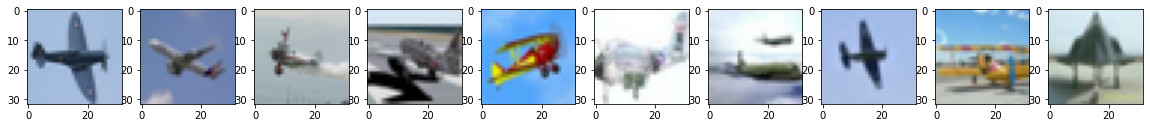

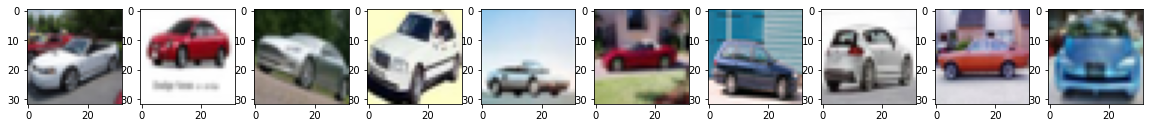

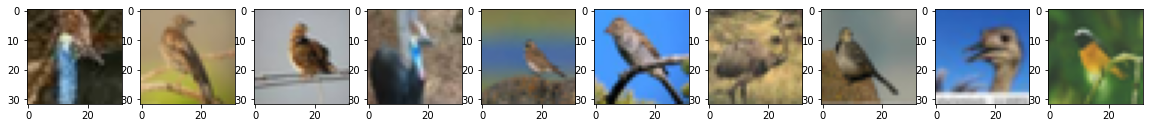

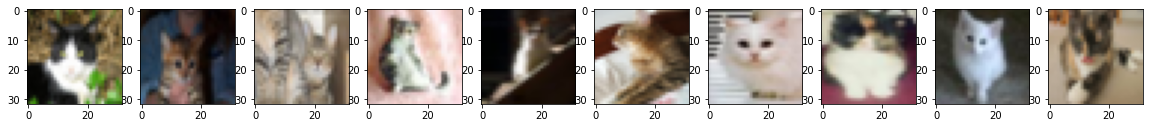

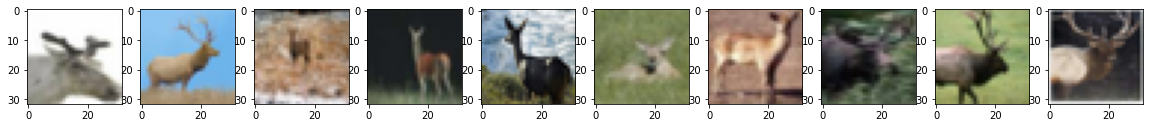

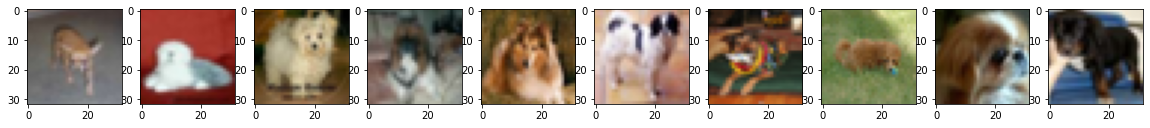

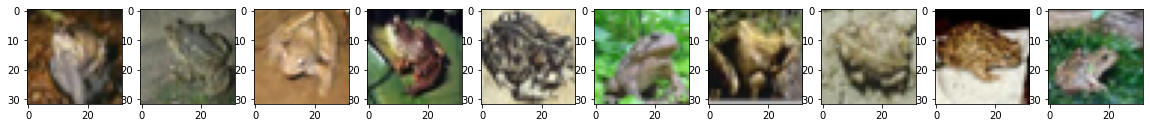

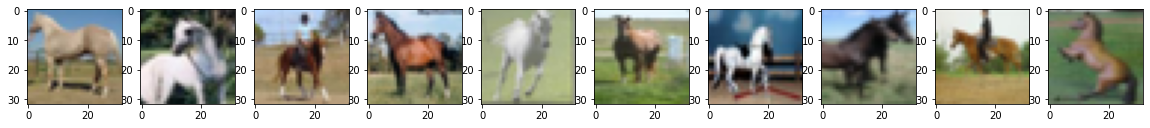

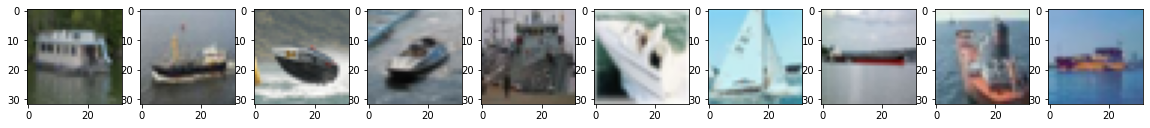

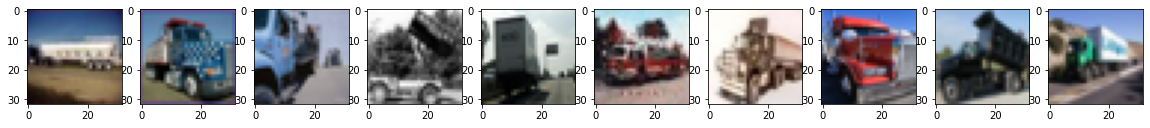

In [13]:
explore_data(X_train, y_train, X_valid, y_valid, X_test, y_test, False)

### Preprocessing the data

Classes used for model training:
<li>bird</li>								
<li>deer</li>																								
<li>horse</li>

Images in the dataset have different lighting conditions and are at different
angles. There are horses in different positions, activities, whole horses or just the head.
Horse images also include those with a horse rider; these images were not considered to be useful
but were not removed from the dataset.

In [14]:
# Preprocessing the data to contain only relevant images for binary classification

X_train, y_train = preProcess(X_train, y_train)
X_valid, y_valid = preProcess(X_valid, y_valid)
X_test, y_test = preProcess(X_test, y_test)

# Inspect size of datasets after preprocessing
display_shape(X_train, y_train, X_valid, y_valid, X_test, y_test)

 X_train shape :(12000, 32, 32, 3)
 X_valid shape :(3000, 32, 32, 3)
 X_test shape :(3000, 32, 32, 3)

 y_train shape :(12000, 1)
 y_valid shape :(3000, 1)
 y_test shape :(3000, 1)

 Unique response parameters in Training Data   : [0 1]
 Unique response parameters in Validation Data : [0 1]
 Unique response parameters in Test Data       : [0 1]




Examples of Images from the Training Dataset per Class


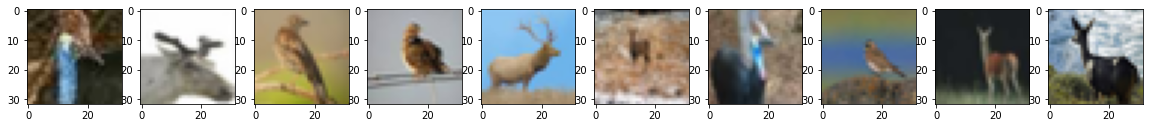

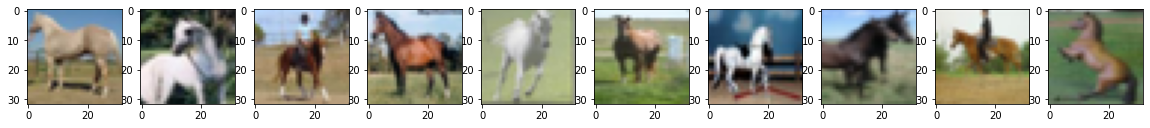

In [15]:
# Exploring data after preprocessing
explore_data(X_train, y_train, X_valid, y_valid, X_test, y_test, False)

### Initial Model 

In [16]:
# Get Initial model
initial_model = define_initial_model()

# Fit the Initial model
initial_model_history = initial_model.fit(X_train,
                                        y_train,
                                        epochs = 20,
                                        batch_size = 256,
                                        validation_data = (X_valid, y_valid),
                                        verbose = 0
                                        )
# Evaluate the initial model
initial_model_results = initial_model.evaluate(X_test, y_test, verbose = 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 2)         56        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 2)         38        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 2)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 8)                 1

#### Evaluating Initial Model Performance
The left graph represents the cross entropy loss of the model on the validation and training set. A lower loss represents better model performance. It can be observed that the loss in the training data set is lower than in the validation set, which indicates overfitting in the model, meaning this inital model will not generalize well to new data.

The observed metrics on the test set also show poor model perfomance.

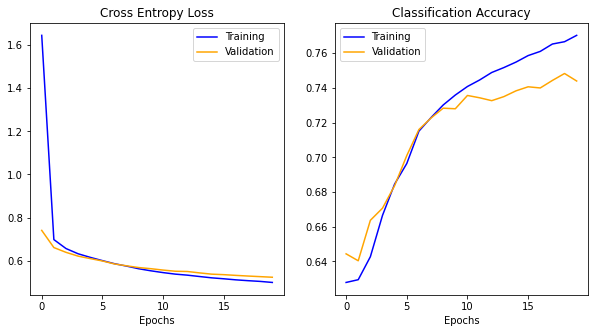

Model Performance on the Test Set
Model Performance
Accuracy : 0.7599999904632568
Precision : 0.6790281534194946
Recall : 0.531000018119812
AUC : 0.7974972724914551
LOSS : 0.5047922730445862


In [17]:
# Plot diagnostics graphs showing model performance on validation set
init_mdl_metrics = summarize_model_diagnostics(initial_model_history, initial_model_results)

#### Predicting with Initial Model  Using Test Set
A model evaluation on that test set also results in metrics that are not ideal, showing how overfitting does not allow the model to generalize well to new data. 

94/94 [==============================] - 0s 3ms/step


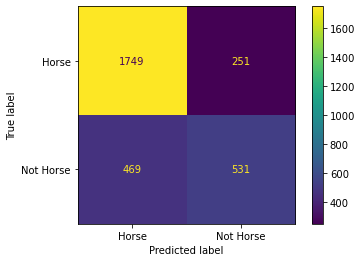

Metrics for Model Performance on the Testing Set
              precision    recall  f1-score   support

       Horse       0.87      0.79      0.83      2218
   Not Horse       0.53      0.68      0.60       782

    accuracy                           0.76      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.78      0.76      0.77      3000



In [18]:
# Predicting and evaluating the initial model with test set
init_predictions = np.round_(initial_model.predict(X_test))

# Plot confusion matrix and display classification report for test data set
display_confMatrix_classReport(init_predictions, y_test)

#### Performance of Initial Model

<li>The initial model shows poor performance based on the metrics observed in the testing data</li>
<li>With only 1287 trainable parameters, the metrics (precision, recall, f1-score) are not optimal</li>
<li>Additional convolution/pooling/dense layers and regularization can help improve model performance</li>

### Model Optimization

In [19]:
# Get Optimized model
optimized_model = define_optimized_model()
# Fit the Optimized model
optimized_model_history = optimized_model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 128,
    validation_data = (X_valid, y_valid),
    callbacks = [EarlyStopping(monitor="val_loss", patience=5)],
    verbose = 0
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 128)       

#### Evaluating Optimized Model Performance
The cross entropy loss graph shows that the loss on the training and validation set are similiar so there is no overfitting in this model. Accuracy increases as epochs increase which also indicates improvement in model performance. 

Metrics measured for the test set also show a signicant increase in model performance.

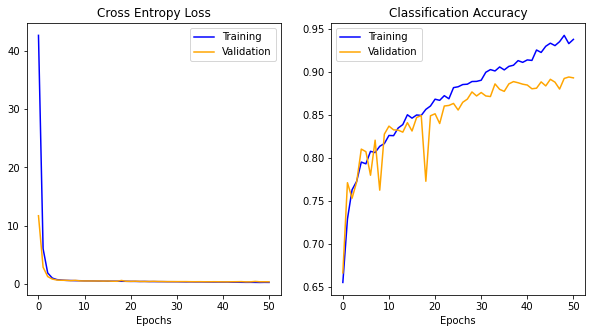

Model Performance on the Test Set
Model Performance
Accuracy : 0.8933333158493042
Precision : 0.8640257120132446
Recall : 0.8069999814033508
AUC : 0.953370988368988
LOSS : 0.38114774227142334


In [20]:
# Evaluate the Optimized model
optimized_model_results = optimized_model.evaluate(X_test, y_test, verbose = 0)

# Plot diagnostics graphs showing model performance
optm_mdl_metrics = summarize_model_diagnostics(optimized_model_history, optimized_model_results)

#### Confusion Matrix: Predictions on Test Set

A confusion matrix report reveals improved metrics indicating the model is generalizing well to new data and is performing significantly better than the initial model.

94/94 [==============================] - 1s 9ms/step


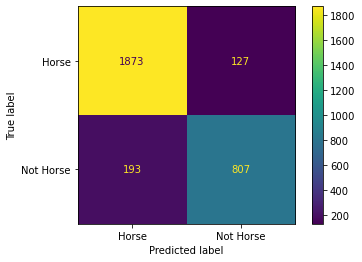

Metrics for Model Performance on the Testing Set
              precision    recall  f1-score   support

       Horse       0.94      0.91      0.92      2066
   Not Horse       0.81      0.86      0.83       934

    accuracy                           0.89      3000
   macro avg       0.87      0.89      0.88      3000
weighted avg       0.90      0.89      0.89      3000



In [21]:
# Predicting and evaluating the initial model with test set
optimized_predictions = np.round_(optimized_model.predict(X_test))

# Plot Confusion Matrix and display classification report for test data set
display_confMatrix_classReport(optimized_predictions, y_test)

#### Performance of Optimized Model

<li>Improved metrics (precision, recall, f1-score) indicate optimization improved model performance</li>
<li>Their is no indication of overfitting suggeseting the model performs well with new data</li>

#### Inspecting correct predictions and misclassifications of the optimized model

<li>Deer can be misclassified as horses</li>
<li>Horse images having only the head and neck are misclassified as non horses</li>
<li>Horse images with humans(riding or standing) are misclassified as non horses</li>


Incorrectly classified as horses


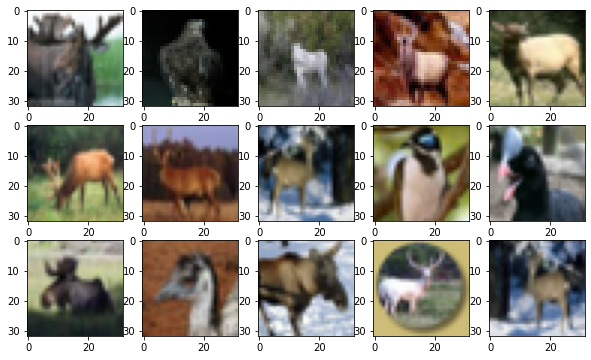


Incorrectly classified as non horses


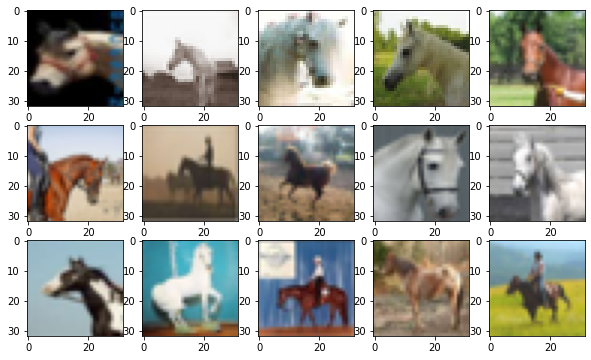

In [22]:
# Extracting indexes for incorrect predictions (for horses and non horses)
incorrect_prediction_indices = (np.where(optimized_predictions != y_test)[0]).reshape(-1)
incorrect_non_horse_indices = np.asarray(np.where(y_test[incorrect_prediction_indices] == 0)).reshape(-1)
incorrect_horse_indices = np.asarray(np.where(y_test[incorrect_prediction_indices] == 1) ).reshape(-1)

# Plotting few non horse images which are incorrectly predicted as horse 
print("\nIncorrectly classified as horses")
display_images(X_test[incorrect_prediction_indices], incorrect_non_horse_indices, 5, 3)

# Plotting few horse images which are incorrectly predicted as non horse 
print("\nIncorrectly classified as non horses")
display_images(X_test[incorrect_prediction_indices], incorrect_horse_indices, 5, 3)

#### Feature maps in optimized model
Feature maps for an example image of a horse were computed by passing the image through the optimized network and getting the output from the first convolutional layer and the first pooling layer.

* Horse image passed through the optimized network

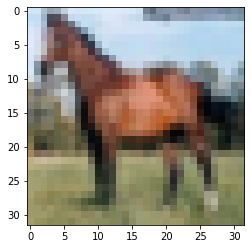

In [23]:
# Filtering for horse images
horse_index = np.where(y_train == 1)[0]
horse = X_train[horse_index[:1000]]
plt.imshow(horse[3])

In [24]:
# Create list of layer outputs
layer_outputs = [layer.output for layer in optimized_model.layers] 

# Create a model that will return the outputs at each layer
layers_model = keras.Model(inputs=optimized_model.input, outputs=layer_outputs) 

# Get predictions for each layer of the network
outputs = layers_model.predict(horse) 
conv_output = outputs[0]
pooling_output = outputs[1]

32/32 [==============================] - 0s 9ms/step


Nine images of the feature maps created through the first convolutional layer are observed below followed by their corresponding image after each goes through pooling in the pooling layer. It can be observed that the images in the pooling layer have gone through reduction and appear to be much more pixelated as a result. This dimension reduction aids in reducing the computational power used to process the data.

* Extracted features in convolutional layer

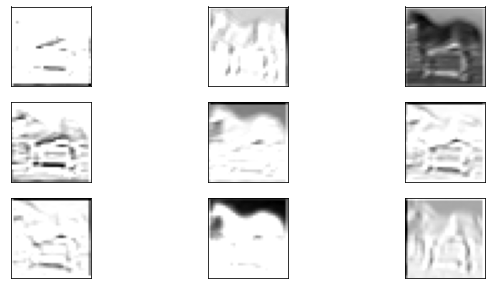

In [25]:
PlotFeatureMaps(conv_output)

* Pooled convoluted features showing reduced dimensionality

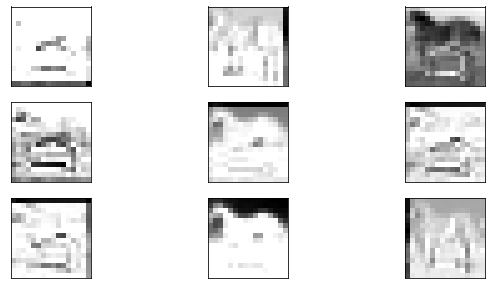

In [26]:
PlotFeatureMaps(pooling_output)

### Model Performance Initial Model vs Optimized Model
Comparing the metrics for performance on the test set indicates that the optimized model is appropriate to classify horse images. The value for the metrics show improvement after optimization and are significantly higher than in the initial model.

In [27]:
# metrics for initial and optimized model on test set
mdl_cmpr_df  = pd.DataFrame(data = {'Metric': [], 'Initial Model': [], 'Optimized Model': []} )
mdl_cmpr_df.loc[len(mdl_cmpr_df.index)] = ["Accuracy", init_mdl_metrics[0], optm_mdl_metrics[0]]
mdl_cmpr_df.loc[len(mdl_cmpr_df.index)] = ["Precision", init_mdl_metrics[1], optm_mdl_metrics[1]]
mdl_cmpr_df.loc[len(mdl_cmpr_df.index)] = ["Recall", init_mdl_metrics[2], optm_mdl_metrics[2]]
mdl_cmpr_df.loc[len(mdl_cmpr_df.index)] = ["AUC", init_mdl_metrics[3], optm_mdl_metrics[3]]
mdl_cmpr_df

,Metric,Initial Model,Optimized Model
0,Accuracy,0.760000,0.893333
1,Precision,0.679028,0.864026
2,Recall,0.531000,0.807000
3,AUC,0.797497,0.953371


__Conclusion__

<li>Our optimized model performed better with 89.3% accuracy and 86.4% precision and 80.7 % recall</li>
<li>We can continuously retrain the model with additional images</li>
<li>Considering the dataset is small, future steps can also include data augmentation to apply transformations like image rotation</li>